# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

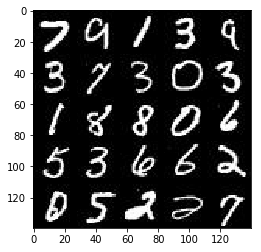

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

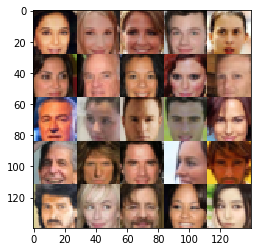

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image=tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name="input_real")
    Z_input=tf.placeholder(tf.float32,[None,z_dim],name="input_z")
    learning_rate=tf.placeholder(tf.float32,name="learning_rate")

    return (input_image,Z_input,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha=0.2
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        norm1 = tf.layers.batch_normalization(layer1, training=True)
        relu1 = tf.maximum(alpha * norm1, norm1)
        #16x16x128
        
        layer2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        norm2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        #8x8x256
        
        layer3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        norm3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)
        #4x4x512

        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha=0.1
    with tf.variable_scope('generator', reuse = reuse):
        #Fully connected layer
        layer1 = tf.layers.dense(z,  7 * 7 * 512)
        #Reshape the fully connected layer to start the convolutional stack
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training = is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        # 7x7x512 now
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides = 2, padding = 'same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        # 14x14x256 now
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 1.9687
Epoch 1/2... Discriminator Loss: 3.1431... Generator Loss: 0.2125
Epoch 1/2... Discriminator Loss: 2.9446... Generator Loss: 0.1635
Epoch 1/2... Discriminator Loss: 2.5224... Generator Loss: 0.2088
Epoch 1/2... Discriminator Loss: 2.3443... Generator Loss: 0.3072
Epoch 1/2... Discriminator Loss: 2.4488... Generator Loss: 0.2285
Epoch 1/2... Discriminator Loss: 2.2608... Generator Loss: 0.2254
Epoch 1/2... Discriminator Loss: 2.2637... Generator Loss: 0.2697
Epoch 1/2... Discriminator Loss: 1.9911... Generator Loss: 0.4268
Epoch 1/2... Discriminator Loss: 1.9285... Generator Loss: 0.3717


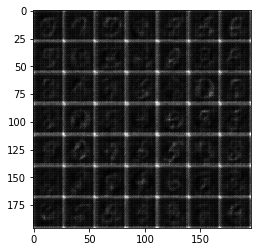

Epoch 1/2... Discriminator Loss: 1.7541... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.7908... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 1.7002... Generator Loss: 0.3872
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 0.3423
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.6983... Generator Loss: 0.3582
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.4439


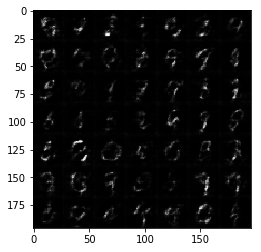

Epoch 1/2... Discriminator Loss: 1.7996... Generator Loss: 0.3462
Epoch 1/2... Discriminator Loss: 1.5491... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.7551... Generator Loss: 0.3461
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.7359... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 0.5749
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.6053... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.6168
Epoch 1/2... Discriminator Loss: 1.7914... Generator Loss: 0.3190


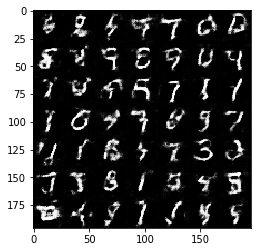

Epoch 1/2... Discriminator Loss: 1.5969... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.6391... Generator Loss: 0.4696
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.6935... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 0.6757
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.6299... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.6507... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 1.7099... Generator Loss: 0.3756


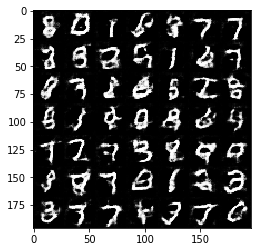

Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 1.5283... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.5955... Generator Loss: 0.5518
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.5385... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.6200... Generator Loss: 0.5493


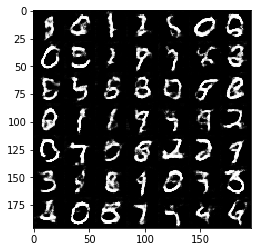

Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.4868
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.6610... Generator Loss: 0.4128
Epoch 1/2... Discriminator Loss: 1.5766... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.4964... Generator Loss: 0.5828
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.8257... Generator Loss: 0.3104
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.8868


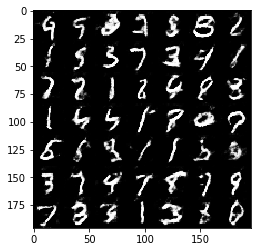

Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.5092... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.8522... Generator Loss: 0.3111
Epoch 1/2... Discriminator Loss: 1.5342... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.5485... Generator Loss: 0.5540
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.7542


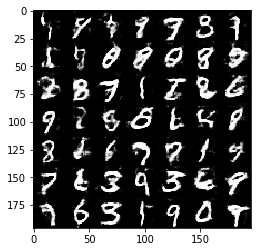

Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.5147
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 1.5907... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 0.5191
Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.5199... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 1.5415... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.6727


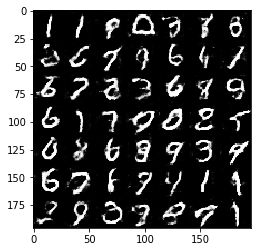

Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.4569
Epoch 1/2... Discriminator Loss: 1.5381... Generator Loss: 0.4815
Epoch 1/2... Discriminator Loss: 1.5611... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.7865


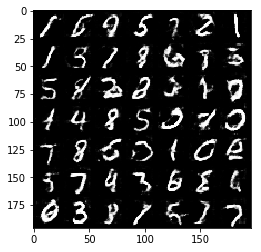

Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.5551... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.5409... Generator Loss: 0.6398
Epoch 2/2... Discriminator Loss: 1.6047... Generator Loss: 0.4511


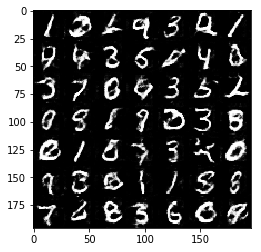

Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 0.3709
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.5208... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.5305
Epoch 2/2... Discriminator Loss: 1.8007... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.4833... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 1.5155... Generator Loss: 0.5502


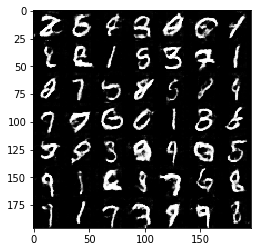

Epoch 2/2... Discriminator Loss: 1.5367... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.5968... Generator Loss: 0.5311
Epoch 2/2... Discriminator Loss: 1.4967... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.6732... Generator Loss: 0.3889
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.9650
Epoch 2/2... Discriminator Loss: 1.5374... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.4965... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 1.6107... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 1.6316... Generator Loss: 0.8902


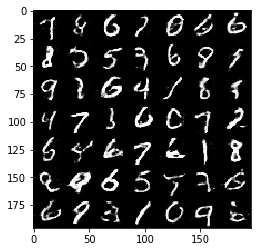

Epoch 2/2... Discriminator Loss: 1.5621... Generator Loss: 0.4575
Epoch 2/2... Discriminator Loss: 1.5193... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.5425... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.6439... Generator Loss: 0.4470
Epoch 2/2... Discriminator Loss: 1.5294... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 1.5061... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.6133... Generator Loss: 0.3997


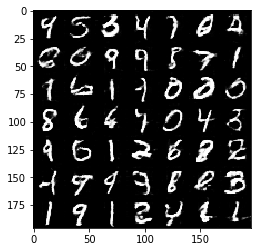

Epoch 2/2... Discriminator Loss: 1.5293... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.5613... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 0.5945
Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.4786
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.3607
Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 0.4980
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.5242... Generator Loss: 0.7088


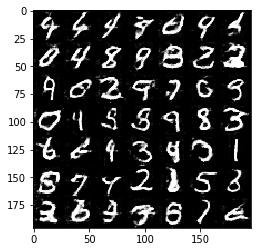

Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.4937... Generator Loss: 0.5466
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.6950... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.5046... Generator Loss: 0.5792


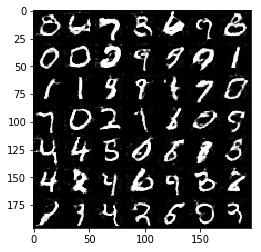

Epoch 2/2... Discriminator Loss: 1.7264... Generator Loss: 0.3409
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 1.5116... Generator Loss: 0.5404
Epoch 2/2... Discriminator Loss: 1.6366... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 1.4779... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 1.5883... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.4931... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 1.6218... Generator Loss: 0.4319


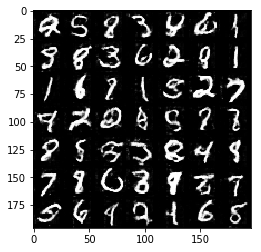

Epoch 2/2... Discriminator Loss: 1.5459... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 1.5868... Generator Loss: 0.4982
Epoch 2/2... Discriminator Loss: 1.6114... Generator Loss: 0.4003
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.6123... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.5079... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.5181


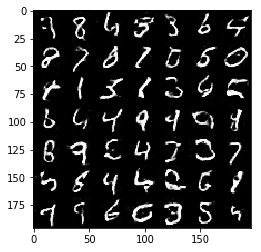

Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 1.5293... Generator Loss: 0.4698
Epoch 2/2... Discriminator Loss: 1.5919... Generator Loss: 0.4709
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 0.3916
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.7707
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.4832... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 0.7156
Epoch 2/2... Discriminator Loss: 1.5953... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.5526


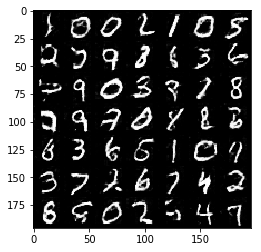

Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.5529... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.5635... Generator Loss: 0.5137
Epoch 2/2... Discriminator Loss: 1.5870... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.6732
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.8097


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.8884... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 2.4782... Generator Loss: 2.0825
Epoch 1/1... Discriminator Loss: 2.9511... Generator Loss: 0.1253
Epoch 1/1... Discriminator Loss: 2.9571... Generator Loss: 0.1484
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 1.3553
Epoch 1/1... Discriminator Loss: 2.3958... Generator Loss: 0.1907
Epoch 1/1... Discriminator Loss: 2.2743... Generator Loss: 0.2200
Epoch 1/1... Discriminator Loss: 2.8102... Generator Loss: 0.1586
Epoch 1/1... Discriminator Loss: 2.0077... Generator Loss: 1.0026


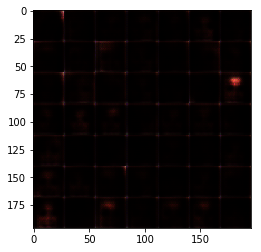

Epoch 1/1... Discriminator Loss: 2.3544... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 2.2608... Generator Loss: 0.2867
Epoch 1/1... Discriminator Loss: 2.1270... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 2.2713... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 1.9629... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.9822... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.9526... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.8879... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 2.0829... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.8464... Generator Loss: 0.4452


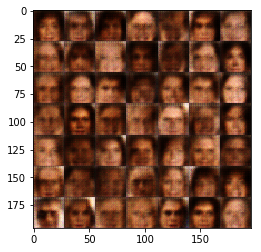

Epoch 1/1... Discriminator Loss: 1.7250... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.8443... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.7792... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.7861... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.8349... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.6732... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 0.5762


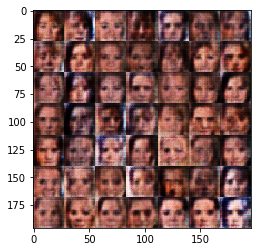

Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.6397


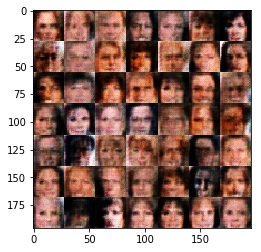

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.6136


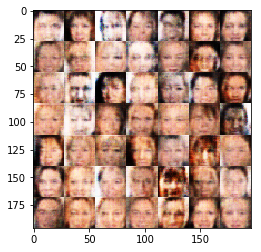

Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.8442


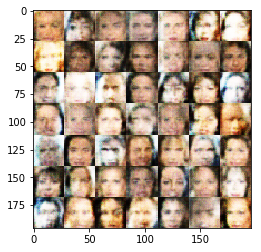

Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5973


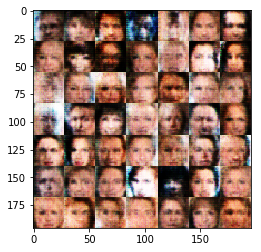

Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7206


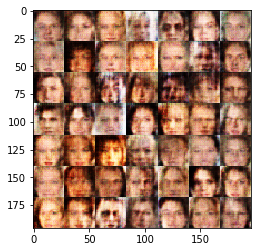

Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.8341


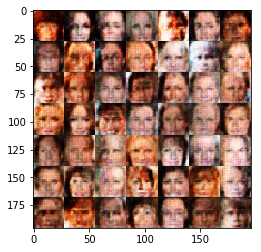

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6733


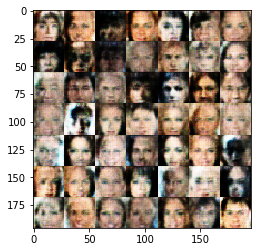

Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7221


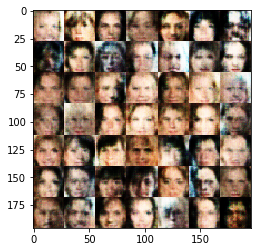

Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.9344


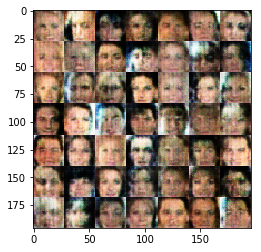

Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8069


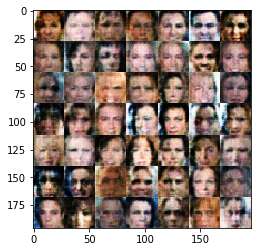

Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7872


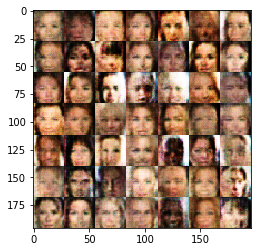

Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.6042


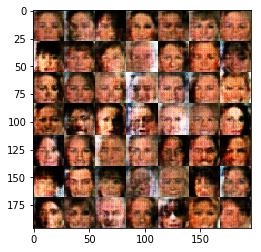

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.6763


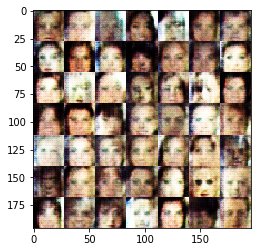

Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7882


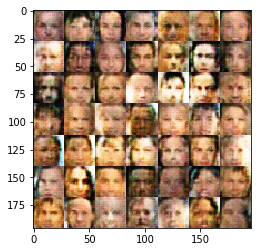

Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6561


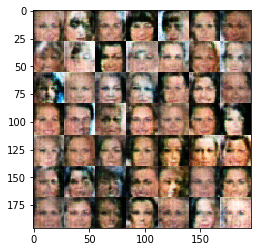

Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.5556


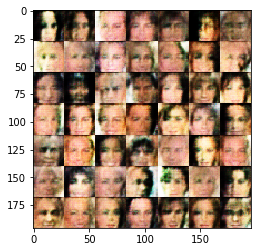

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7241


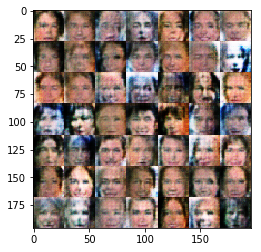

Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6675


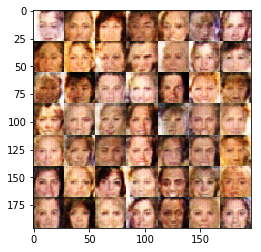

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6665


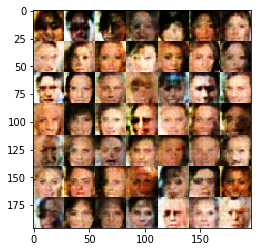

Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.8254


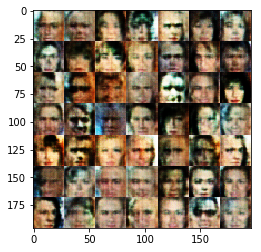

Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.6306


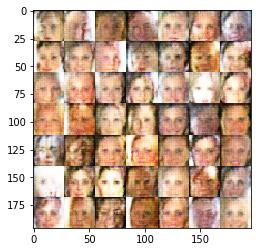

Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7224


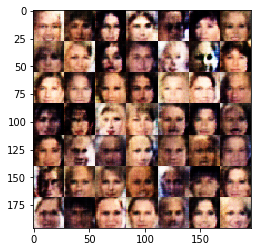

Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6594


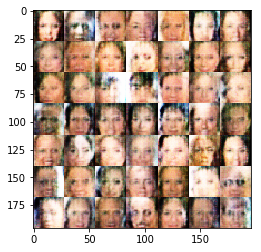

Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5992


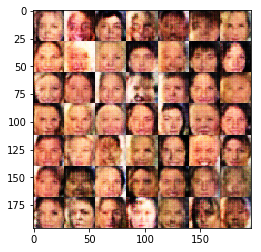

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7310


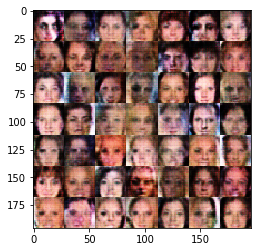

Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 1.0305


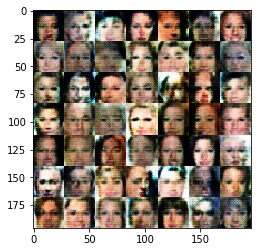

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6965


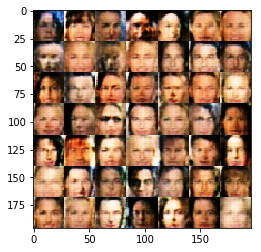

Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6198


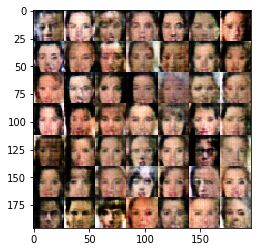

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7950


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.